In [16]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from typing import List, Tuple, Dict
import math
import time
import matplotlib.pyplot as plt
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def calculate_accuracy(model: nn.Module, data_loader: torch.utils.data.DataLoader, device: torch.device) -> float:
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def calculate_accuracy_for_class(model: nn.Module, data_loader: torch.utils.data.DataLoader, device: torch.device, target_class: int = 6) -> float:
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Solo consideramos las imágenes que son de la clase objetivo o que el modelo predice como la clase objetivo
            mask = (labels == target_class) | (predicted == target_class)
            total += mask.sum().item()
            correct += ((predicted == labels) & mask).sum().item()

    return correct / total if total > 0 else 0

def remove_players(model: nn.Module, players: List[Tuple[str, int]]) -> None:
    for layer_name, filter_index in players:
        if hasattr(model, layer_name):
            layer = getattr(model, layer_name)
            if isinstance(layer, nn.Conv2d):
                layer.weight.data[int(filter_index)].fill_(0)
                if layer.bias is not None:
                    layer.bias.data[int(filter_index)] = 0

def get_players(model: nn.Module) -> List[Tuple[str, int]]:
    players = []
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            players.extend([(name, int(i)) for i in range(module.out_channels)])
    return players

def tmab_shapley(model: nn.Module,
                 data_loader: torch.utils.data.DataLoader,
                 device: torch.device,
                 num_players: int,
                 num_samples: int,
                 truncation: float,
                 delta: float,
                 epsilon: float,
                 target_class: int = 6) -> Dict[Tuple[str, int], float]:
    players = get_players(model)
    values = {(str(player[0]), int(player[1])): 0.0 for player in players}
    counts = {(str(player[0]), int(player[1])): 0 for player in players}
    variances = {(str(player[0]), int(player[1])): 0.0 for player in players}

    # Modificado para calcular la precision para la clase 6
    original_accuracy = calculate_accuracy_for_class(model, data_loader, device, target_class)

    for _ in range(num_samples):
        permutation = np.random.permutation(players)
        model_copy = LeNet().to(device)
        model_copy.load_state_dict(model.state_dict())

        accuracy = original_accuracy
        for player in permutation:
            player = (str(player[0]), int(player[1]))
            if accuracy < truncation * original_accuracy:
                break

            remove_players(model_copy, [player])
            new_accuracy = calculate_accuracy_for_class(model_copy, data_loader, device, target_class) # Modificado para calcular la precision para la clase 6
            marginal_contribution = accuracy - new_accuracy

            counts[player] += 1
            old_avg = values[player]
            values[player] += (marginal_contribution - values[player]) / counts[player]
            variances[player] += (marginal_contribution - old_avg) * (marginal_contribution - values[player])

            accuracy = new_accuracy

        # Cálculo de límites de confianza de Bernstein
        for player in players:
            player = (str(player[0]), int(player[1]))
            if counts[player] > 1:
                std_dev = math.sqrt(variances[player] / (counts[player] - 1))
                cb = math.sqrt(2 * math.log(2 / delta) / counts[player]) * std_dev + \
                     7 * math.log(2 / delta) / (3 * (counts[player] - 1))
                upper_bound = values[player] + cb
                lower_bound = values[player] - cb

                k_largest_value = sorted(values.values(), reverse=True)[min(num_players - 1, len(values) - 1)]
                if lower_bound > k_largest_value + epsilon or upper_bound < k_largest_value - epsilon:
                    counts[player] = float('inf')  # Marcar como inactivo para MAB

        # Implementación del enfoque MAB
        active_players = [p for p in players if counts[(str(p[0]), int(p[1]))] < float('inf')]
        if len(active_players) <= num_players:
            break

    return {player: value for player, value in values.items()}

Using device: cpu


In [2]:
# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
num_players = 10
num_samples = 100
truncation = 0.2
delta = 0.1
epsilon = 0.01

# Cargar y preparar datos
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 51844887.30it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1905428.22it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13888782.36it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7180749.63it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
checkpoint = torch.load('/content/drive/MyDrive/DPB4 GradCAM/TMAB - Shapley/Pytorch/lenet_mnist.pth', map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model = LeNet().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# Evaluar el modelo en el conjunto de prueba
test_accuracy = calculate_accuracy(model, testloader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9868


In [5]:
# Ejecutar TMAB Shapley
start_time = time.time()
# shapley_values = tmab_shapley(model, testloader, device, num_players, num_samples, truncation, delta, epsilon)
shapley_values = tmab_shapley(model, testloader, device, num_players, num_samples, truncation, delta, epsilon, target_class=6)  # Modificado para calcular la precision para la clase 6
end_time = time.time()

print(f"Tiempo total de ejecución: {end_time - start_time:.2f} segundos")

# Imprimir resultados
for player, value in sorted(shapley_values.items(), key=lambda x: x[1], reverse=True)[:]:
    print(f"Player {player}: Shapley value = {value:.6f}")

Tiempo total de ejecución: 2155.24 segundos
Player ('conv1', 3): Shapley value = 0.462137
Player ('conv2', 1): Shapley value = 0.165915
Player ('conv1', 5): Shapley value = 0.152454
Player ('conv2', 13): Shapley value = 0.126450
Player ('conv1', 4): Shapley value = 0.123904
Player ('conv2', 8): Shapley value = 0.122041
Player ('conv1', 1): Shapley value = 0.121337
Player ('conv2', 14): Shapley value = 0.117355
Player ('conv2', 9): Shapley value = 0.107361
Player ('conv2', 15): Shapley value = 0.081506
Player ('conv2', 10): Shapley value = 0.071040
Player ('conv2', 12): Shapley value = 0.058890
Player ('conv1', 2): Shapley value = 0.036093
Player ('conv2', 2): Shapley value = 0.028272
Player ('conv1', 0): Shapley value = 0.014223
Player ('conv2', 11): Shapley value = 0.011697
Player ('conv2', 3): Shapley value = 0.009623
Player ('conv2', 5): Shapley value = -0.000728
Player ('conv2', 6): Shapley value = -0.002582
Player ('conv2', 0): Shapley value = -0.003397
Player ('conv2', 4): Shaple

In [6]:
# Ejecutar TMAB Shapley
start_time = time.time()
# shapley_values = tmab_shapley(model, testloader, device, num_players, num_samples, truncation, delta, epsilon)
shapley_values = tmab_shapley(model, testloader, device, num_players, num_samples, truncation, delta, epsilon, target_class=1)  # Modificado para calcular la precision para la clase 1
end_time = time.time()

print(f"Tiempo total de ejecución: {end_time - start_time:.2f} segundos")

# Imprimir resultados
for player, value in sorted(shapley_values.items(), key=lambda x: x[1], reverse=True)[:]:
    print(f"Player {player}: Shapley value = {value:.6f}")

Tiempo total de ejecución: 2064.35 segundos
Player ('conv1', 3): Shapley value = 0.352316
Player ('conv1', 4): Shapley value = 0.347412
Player ('conv2', 2): Shapley value = 0.267730
Player ('conv2', 1): Shapley value = 0.250935
Player ('conv1', 5): Shapley value = 0.101885
Player ('conv2', 9): Shapley value = 0.087369
Player ('conv2', 14): Shapley value = 0.083656
Player ('conv2', 13): Shapley value = 0.074509
Player ('conv2', 10): Shapley value = 0.042817
Player ('conv1', 1): Shapley value = 0.041290
Player ('conv2', 15): Shapley value = 0.038470
Player ('conv2', 0): Shapley value = 0.028789
Player ('conv1', 2): Shapley value = 0.025310
Player ('conv1', 0): Shapley value = 0.021654
Player ('conv2', 3): Shapley value = 0.020786
Player ('conv2', 8): Shapley value = 0.009995
Player ('conv2', 4): Shapley value = 0.004370
Player ('conv2', 6): Shapley value = 0.002832
Player ('conv2', 11): Shapley value = 0.000857
Player ('conv2', 7): Shapley value = -0.002703
Player ('conv2', 5): Shapley v

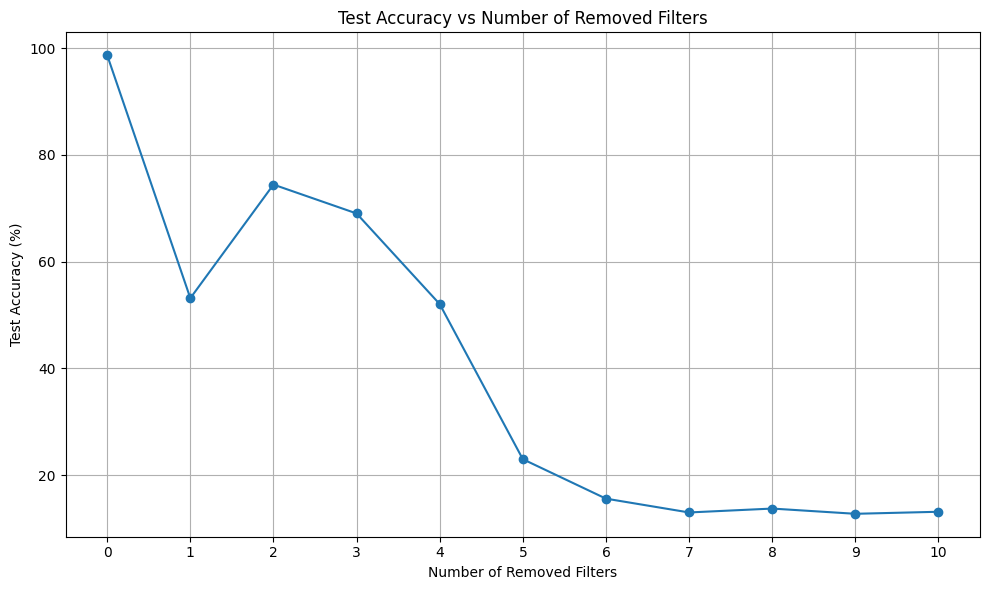

In [5]:
def plot_accuracy_vs_removed_filters(model, testloader, device, important_filters):
    accuracies = []
    num_removed = []

    # Crear una copia del modelo original
    model_copy = copy.deepcopy(model)

    # Calcular la precisión inicial
    initial_accuracy = calculate_accuracy(model_copy, testloader, device) * 100
    accuracies.append(initial_accuracy)
    num_removed.append(0)

    # Eliminar filtros uno por uno y calcular la precisión
    for i, filter in enumerate(important_filters, 1):
        remove_players(model_copy, [filter])
        accuracy = calculate_accuracy(model_copy, testloader, device) * 100
        accuracies.append(accuracy)
        num_removed.append(i)

    # Crear la gráfica
    plt.figure(figsize=(10, 6))
    plt.plot(num_removed, accuracies, marker='o')
    plt.title('Test Accuracy vs Number of Removed Filters')
    plt.xlabel('Number of Removed Filters')
    plt.ylabel('Test Accuracy (%)')
    plt.grid(True)
    plt.xticks(num_removed)
    plt.tight_layout()
    plt.savefig('accuracy_vs_removed_filters.png')
    plt.show()

# Lista de filtros importantes (del más importante al menos importante)
important_filters = [
    ('conv1', 3),
    ('conv1', 5),
    ('conv2', 14),
    ('conv2', 1),
    ('conv1', 4),
    ('conv2', 9),
    ('conv2', 13),
    ('conv2', 2),
    ('conv2', 12),
    ('conv2', 8)
]

# Llamar a la función para crear la gráfica
plot_accuracy_vs_removed_filters(model, testloader, device, important_filters)

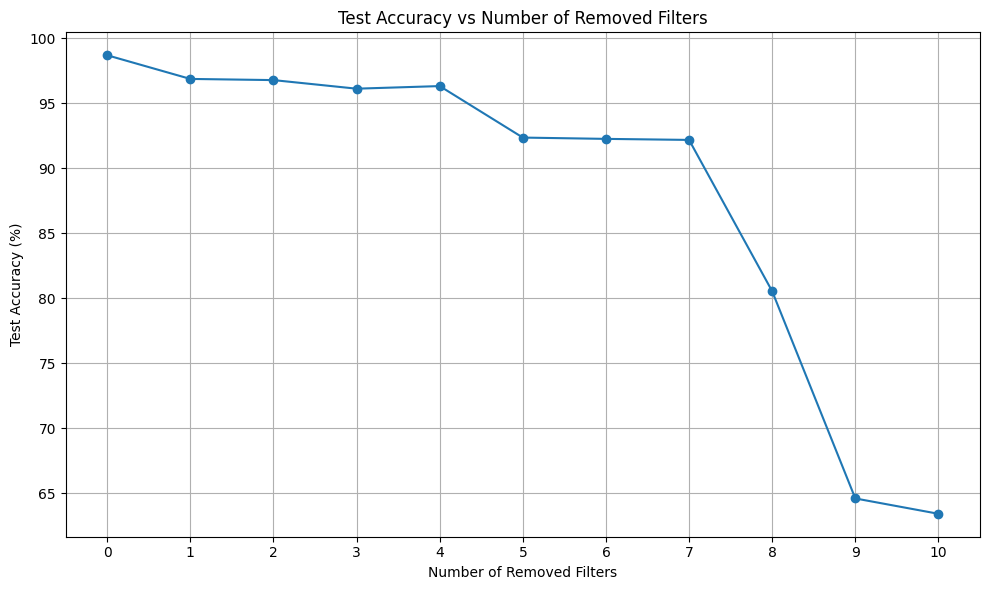

In [7]:
# Lista de los filtros menos importantes
unimportant_filters = [
    ('conv2', 4),
    ('conv2', 6),
    ('conv2', 3),
    ('conv2', 7),
    ('conv1', 1),
    ('conv2', 0),
    ('conv1', 0),
    ('conv2', 11),
    ('conv2', 10),
    ('conv1', 2)
]

# Llamar a la función para crear la gráfica
plot_accuracy_vs_removed_filters(model, testloader, device, unimportant_filters)

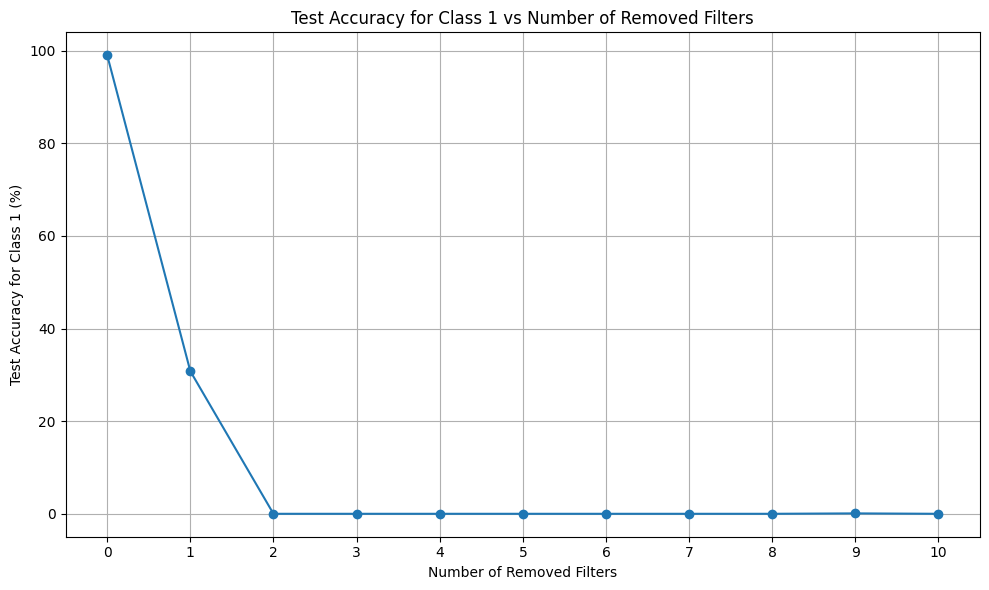

In [14]:
def plot_accuracy_vs_removed_filters(model, testloader, device, important_filters, target_class=6):
    accuracies = []
    num_removed = []

    # Crear una copia del modelo original
    model_copy = copy.deepcopy(model)

    # Calcular la precisión inicial
    initial_accuracy = calculate_accuracy_for_class(model_copy, testloader, device, target_class=target_class) * 100
    accuracies.append(initial_accuracy)
    num_removed.append(0)

    # Eliminar filtros uno por uno y calcular la precisión
    for i, filter in enumerate(important_filters, 1):
        remove_players(model_copy, [filter])
        accuracy = calculate_accuracy_for_class(model_copy, testloader, device, target_class=target_class) * 100
        accuracies.append(accuracy)
        num_removed.append(i)

    # Crear la gráfica
    plt.figure(figsize=(10, 6))
    plt.plot(num_removed, accuracies, marker='o')
    plt.title(f'Test Accuracy for Class {target_class} vs Number of Removed Filters')
    plt.xlabel('Number of Removed Filters')
    plt.ylabel(f'Test Accuracy for Class {target_class} (%)')
    plt.grid(True)
    plt.xticks(num_removed)
    plt.tight_layout()
    plt.savefig(f'accuracy_vs_removed_filters_class_{target_class}.png')
    plt.show()

top_10_filters = [
    ('conv1', 3),
    ('conv1', 4),
    ('conv2', 2),
    ('conv2', 1),
    ('conv1', 5),
    ('conv2', 9),
    ('conv2', 14),
    ('conv2', 13),
    ('conv2', 10),
    ('conv1', 1)
]

# Llamar a la función para crear la gráfica
plot_accuracy_vs_removed_filters(model, testloader, device, top_10_filters, target_class=1)

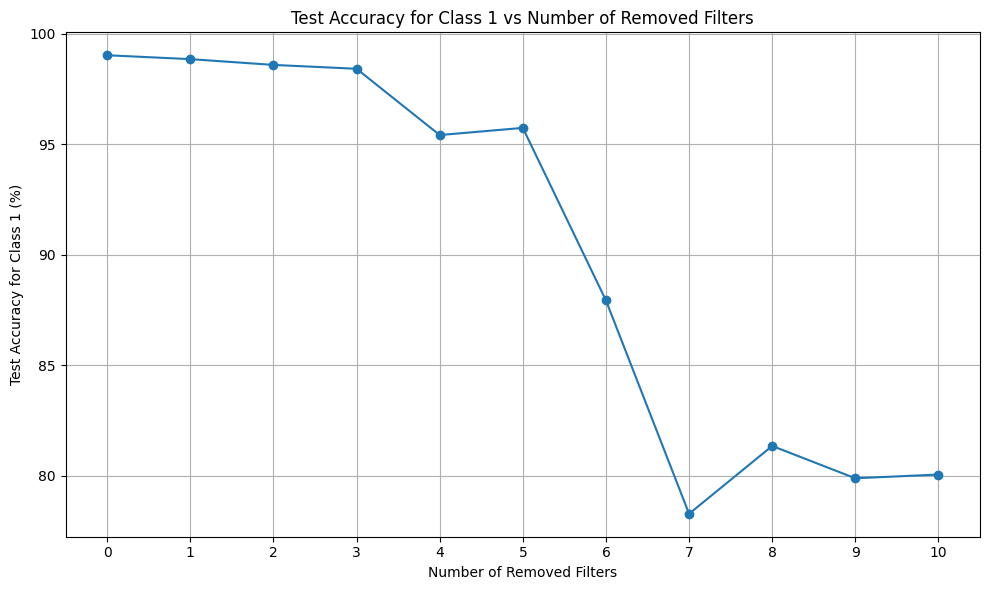

In [15]:
bottom_10_filters = [
    ('conv2', 12),
    ('conv2', 5),
    ('conv2', 7),
    ('conv2', 11),
    ('conv2', 6),
    ('conv2', 4),
    ('conv2', 8),
    ('conv2', 3),
    ('conv1', 0),
    ('conv1', 2)
]

# Llamar a la función para crear la gráfica
plot_accuracy_vs_removed_filters(model, testloader, device, bottom_10_filters, target_class=1)